# IBI Workbook

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from math import factorial
from scipy.interpolate import CubicSpline
%matplotlib inline
from rep_spline import RepulsivePotenial

In [3]:
def loadrdf(filename):
    with open(filename, 'r') as f:
        x, y = np.loadtxt(f, usecols=(0, 1), unpack=True)
    return (x, y)
def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    if not (isinstance(window_size, int) and isinstance(order, int)):
        raise ValueError("window_size and order must be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError('window_size must be a positive odd number')
    if window_size < order + 2:
        raise TypeError('window_size is too small for the polynomials order')

    order_range = range(order+1)
    half_window = (window_size - 1) // 2
    b = np.mat([[k**i for i in order_range] for k in range(-half_window,
                                                           half_window +1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    firstvals = y[0] - np.abs(y[1:half_window+1][::-1] - y[0])
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve(m[::-1], y, mode='valid')

In [4]:
target_rdf = loadrdf('cp2k/rdf_oo_py.dat')
calc_rdf = loadrdf('dftb/iter_0_big/rdf_oo_py.dat')
calc_rdf2 = loadrdf('dftb/iter_0/rdf_oo_py.dat')


FileNotFoundError: [Errno 2] No such file or directory: 'cp2k/rdf_oo_py.dat'

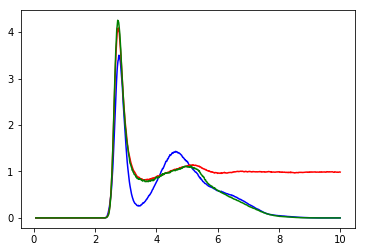

In [46]:
plt.plot(target_rdf[0], target_rdf[1], 'b-')
plt.plot(calc_rdf[0], calc_rdf[1], 'r-')
plt.plot(calc_rdf2[0], calc_rdf2[1], 'g-')

In [48]:
#np.savetxt('smooth.dat', np.transpose([x, yhat]))

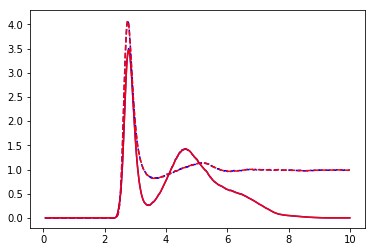

In [50]:
target_ys = savitzky_golay(target_rdf[1], 19, 3)
plt.plot(target_rdf[0], target_rdf[1], 'b-')
plt.plot(target_rdf[0], target_ys, 'r-')
calc_ys = savitzky_golay(calc_rdf[1], 19, 3)
plt.plot(calc_rdf[0], calc_rdf[1], 'b--')
plt.plot(calc_rdf[0], calc_ys, 'r--')

# Cubic spline interpolation

In [69]:
from scipy.interpolate import CubicSpline
spline_target = CubicSpline(target_rdf[0], target_ys)
spline_calc = CubicSpline(calc_rdf[0], calc_ys)

Plot the interpolated rdf to check

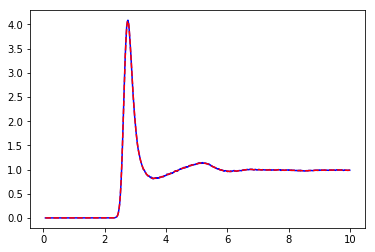

In [70]:
plt.plot(calc_rdf[0], calc_rdf[1], 'b-')
plt.plot(calc_rdf[0], spline_calc(calc_rdf[0]), 'r--')

# Compute the delta F

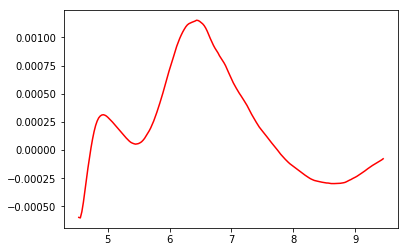

In [94]:
Kb=3.166811429e-6
kbt = Kb*300.0

cutoff = 5.0/0.529177
starting = 2.4/0.529177
grids = np.linspace(starting, cutoff, 200)

def ibi(r):
    try:
        g_ref = spline_target(r*0.529177)
        g_calc = spline_calc(r*0.529177)
        delta_f = kbt*math.log(g_calc/g_ref)
        return delta_f
    except:
        return 0.0

fs = [ibi(r) for r in grids]
    
plt.plot(grids, fs, 'r-')


In [148]:
from rep_spline import RepulsivePotenial
%matplotlib notebook

In [77]:
skfile = RepulsivePotenial.from_file('O-O.skf')

<IPython.core.display.Javascript object>


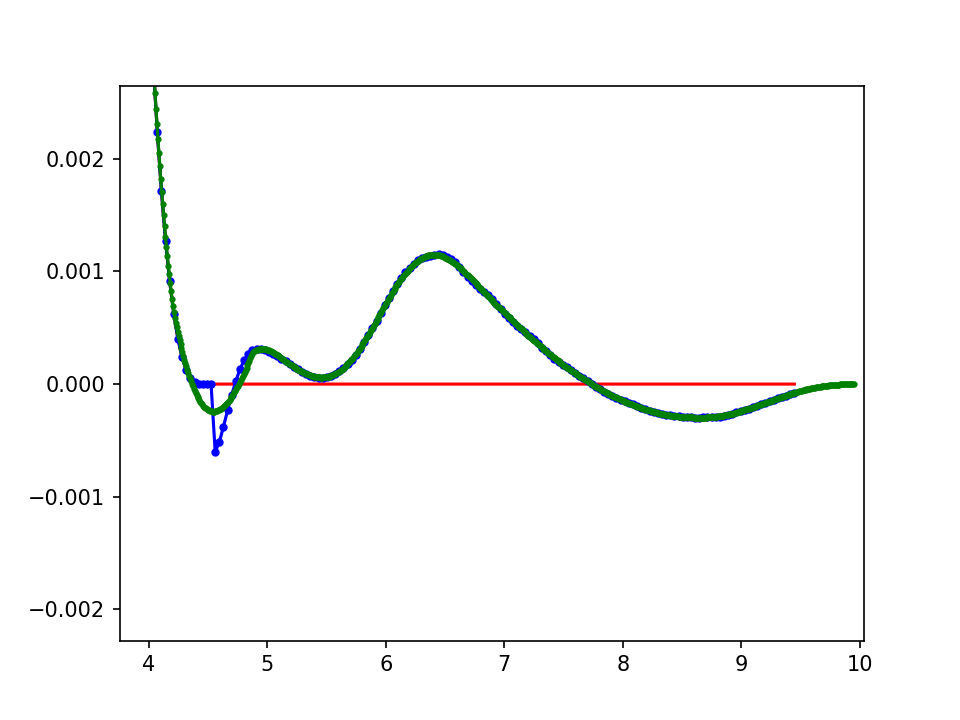

In [180]:
grids = np.linspace(skfile.knots[-1]-2.0, cutoff, 200) 
final_rep = []
ori_rep = []
fs = []
for r in grids:
    if r <= starting:
        fs.append(0.0)
        final_rep.append(skfile.eval(r))
    else:
        fs.append(ibi(r))
        final_rep.append(skfile.eval(r)+ibi(r))
    ori_rep.append(skfile.eval(r))

final_rep_smooth = savitzky_golay(np.array(final_rep), 19, 3)

final_grids = []
final_pot = []
for r in skfile.knots:
    if r < skfile.knots[-1]-1.0:
        final_grids.append(r)
        final_pot.append(skfile.eval(r))
for r, v in zip(grids, final_rep_smooth):
    if r >= skfile.knots[-1]-1.0:
        final_grids.append(r)
        final_pot.append(v)

real_cutoff = cutoff+0.5
final_grids.append(real_cutoff)
final_pot.append(0.0)

first_deriv = skfile.eval(final_grids[0], 1)
final_splines = CubicSpline(final_grids, final_pot, bc_type=((1, first_deriv), (1, 0.0)))

ploting_grids = np.linspace(skfile.knots[0], real_cutoff, 1000)

#plt.plot(grids, fs, 'r-')
plt.plot(grids, ori_rep, 'r-')
plt.plot(grids, final_rep, 'bo-', markersize=3)
plt.plot(ploting_grids, final_splines(ploting_grids), 'go-', markersize=2)
# plt.xlim(4, 10)
# plt.ylim(-0.002, 0.005)


Downsample the final repulsive potential

In [191]:
#Fit the first derivatives
resolution = 0.01
nknots = int((real_cutoff - skfile.knots[0])/resolution)+1
final_knots = np.linspace(skfile.knots[0], real_cutoff, nknots)
pot_values = [final_splines(r, 0) for r in final_knots]
first_derivs = [final_splines(r, 1) for r in final_knots]
second_deriv = skfile.eval(final_knots[0], 2)
first_derivs_splines = CubicSpline(final_knots, first_derivs, bc_type=((1, second_deriv), (1, 0.0)))
# print(first_derivs_splines.c)
a4, a3, a2, a1 = first_derivs_splines.c
# print(first_derivs[0], a1[0])
# print(len(first_derivs_splines.x), len(a1))

r = skfile.knots[0]
new_expA = -first_derivs_splines(r,1)/first_derivs_splines(r) 
new_expB = math.log(-first_derivs_splines(r)/new_expA) + new_expA*r
new_expC = final_splines(r, 0) - math.exp(-new_expA*r+new_expB)
# print(new_expA, new_expB, new_expC)
# print(skfile.expA, skfile.expB, skfile.expC)

with open('output.rep', 'w') as f:
    print('Spline4', file=f)
    print(len(a1), real_cutoff, file=f)
    print(new_expA, new_expB, new_expC, file=f)
    
    for i in range(len(a1)):
        print('{:<7.4f} {:<7.4f} {:18.10E} {:18.10E} {:18.10E} {:18.10E} {:18.10E}'.format(
            first_derivs_splines.x[i], first_derivs_splines.x[i+1], pot_values[i], a1[i], a2[i]/2.0, a3[i]/3.0, a4[i]/4.0
        ), file=f)

# Iteration 2

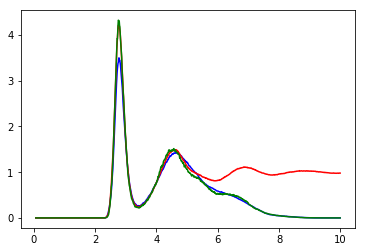

In [5]:
target_rdf = loadrdf('cp2k/rdf_oo_py.dat')
calc_rdf = loadrdf('dftb/iter_1_big/rdf_oo_py.dat')
calc_rdf2 = loadrdf('dftb/iter_1/rdf_oo_py.dat')
plt.plot(target_rdf[0], target_rdf[1], 'b-')
plt.plot(calc_rdf[0], calc_rdf[1], 'r-')
plt.plot(calc_rdf2[0], calc_rdf2[1], 'g-')

## Smooth the curves

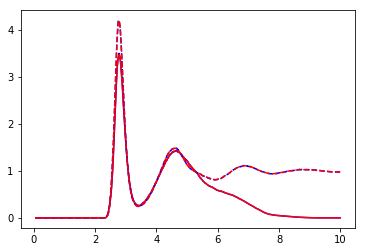

In [6]:
target_ys = savitzky_golay(target_rdf[1], 19, 3)
plt.plot(target_rdf[0], target_rdf[1], 'b-')
plt.plot(target_rdf[0], target_ys, 'r-')
calc_ys = savitzky_golay(calc_rdf[1], 19, 3)
plt.plot(calc_rdf[0], calc_rdf[1], 'b--')
plt.plot(calc_rdf[0], calc_ys, 'r--')

## Make Spline Interpolations

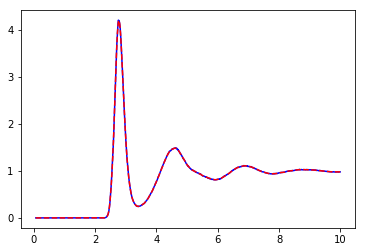

In [7]:

spline_target = CubicSpline(target_rdf[0], target_ys)
spline_calc = CubicSpline(calc_rdf[0], calc_ys)
plt.plot(calc_rdf[0], calc_rdf[1], 'b-')
plt.plot(calc_rdf[0], spline_calc(calc_rdf[0]), 'r--')

## Compute the Delta F

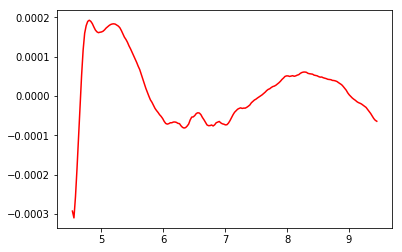

In [16]:
Kb=3.166811429e-6
kbt = Kb*300.0

cutoff = 5.0/0.529177
starting = 2.4/0.529177
grids = np.linspace(starting, cutoff, 200)

def ibi(r):
    try:
        g_ref = spline_target(r*0.529177)
        g_calc = spline_calc(r*0.529177)
        delta_f = kbt*math.log(g_calc/g_ref)
        return delta_f
    except:
        return 0.0

fs = [ibi(r) for r in grids]
    
plt.plot(grids, fs, 'r-')

In [19]:

skfile = RepulsivePotenial.from_file('dftb/iter_1/O-O.skf')

<IPython.core.display.Javascript object>


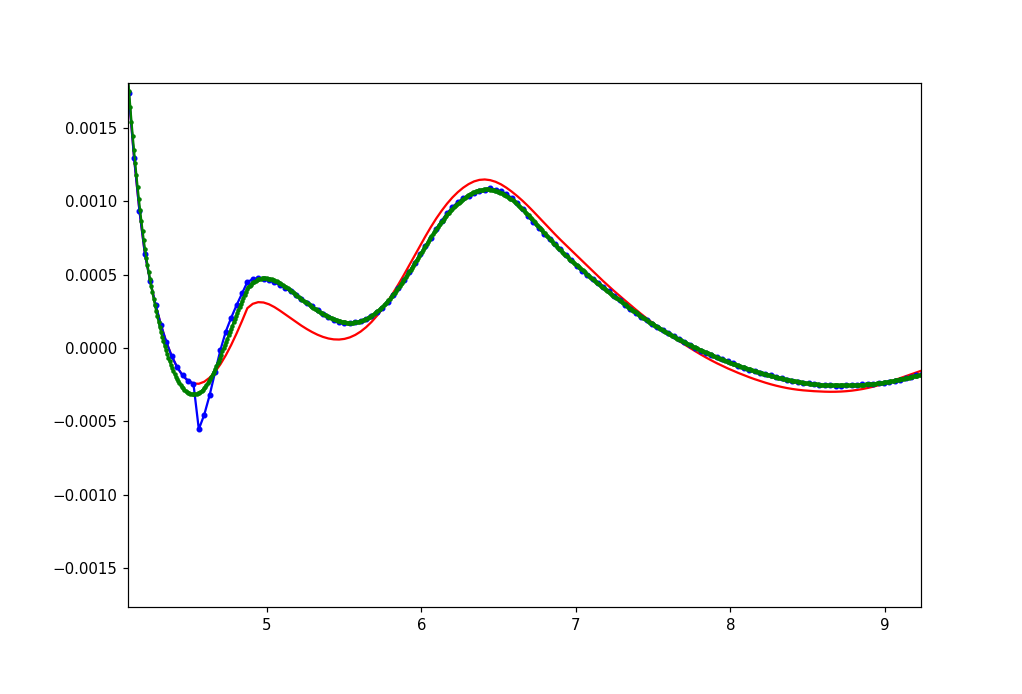

In [20]:
fit_start = 4.5
grids = np.linspace(fit_start-2.0, cutoff, 200) 
final_rep = []
ori_rep = []
fs = []
for r in grids:
    if r <= starting:
        fs.append(0.0)
        final_rep.append(skfile.eval(r))
    else:
        fs.append(ibi(r))
        final_rep.append(skfile.eval(r)+ibi(r))
    ori_rep.append(skfile.eval(r))

final_rep_smooth = savitzky_golay(np.array(final_rep), 19, 3)

final_grids = []
final_pot = []
for r in skfile.knots:
    if r < fit_start-1.0:
        final_grids.append(r)
        final_pot.append(skfile.eval(r))
for r, v in zip(grids, final_rep_smooth):
    if r >= fit_start-1.0:
        final_grids.append(r)
        final_pot.append(v)

real_cutoff = cutoff+0.5
final_grids.append(real_cutoff)
final_pot.append(0.0)

first_deriv = skfile.eval(final_grids[0], 1)
final_splines = CubicSpline(final_grids, final_pot, bc_type=((1, first_deriv), (1, 0.0)))

ploting_grids = np.linspace(skfile.knots[0], real_cutoff, 1000)

#plt.plot(grids, fs, 'r-')
plt.plot(grids, ori_rep, 'r-')
plt.plot(grids, final_rep, 'bo-', markersize=3)
plt.plot(ploting_grids, final_splines(ploting_grids), 'go-', markersize=2)
# plt.xlim(4, 10)
# plt.ylim(-0.002, 0.005)

In [21]:
#Fit the first derivatives
resolution = 0.01
nknots = int((real_cutoff - skfile.knots[0])/resolution)+1
final_knots = np.linspace(skfile.knots[0], real_cutoff, nknots)
pot_values = [final_splines(r, 0) for r in final_knots]
first_derivs = [final_splines(r, 1) for r in final_knots]
second_deriv = skfile.eval(final_knots[0], 2)
first_derivs_splines = CubicSpline(final_knots, first_derivs, bc_type=((1, second_deriv), (1, 0.0)))
# print(first_derivs_splines.c)
a4, a3, a2, a1 = first_derivs_splines.c
# print(first_derivs[0], a1[0])
# print(len(first_derivs_splines.x), len(a1))

r = skfile.knots[0]
new_expA = -first_derivs_splines(r,1)/first_derivs_splines(r) 
new_expB = math.log(-first_derivs_splines(r)/new_expA) + new_expA*r
new_expC = final_splines(r, 0) - math.exp(-new_expA*r+new_expB)
# print(new_expA, new_expB, new_expC)
# print(skfile.expA, skfile.expB, skfile.expC)

with open('output_2.rep', 'w') as f:
    print('Spline4', file=f)
    print('{} {:<7.4f}'.format(len(a1), real_cutoff), file=f)
    print(new_expA, new_expB, new_expC, file=f)
    
    for i in range(len(a1)):
        print('{:<7.4f} {:<7.4f} {:18.10E} {:18.10E} {:18.10E} {:18.10E} {:18.10E}'.format(
            first_derivs_splines.x[i], first_derivs_splines.x[i+1], pot_values[i], a1[i], a2[i]/2.0, a3[i]/3.0, a4[i]/4.0
        ), file=f)

# Iteration 3

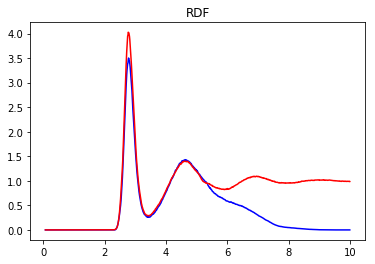

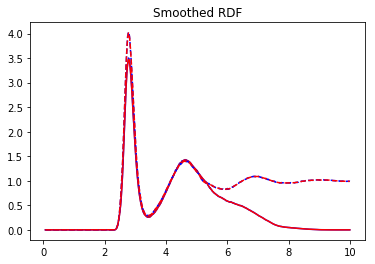

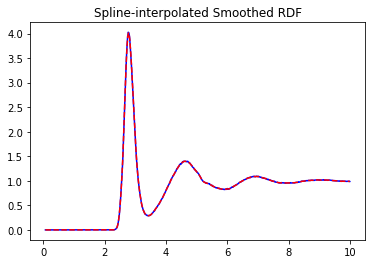

In [30]:
target_rdf = loadrdf('cp2k/rdf_oo_py.dat')
calc_rdf = loadrdf('dftb/iter_2_big/rdf_oo_py.dat')
plt.plot(target_rdf[0], target_rdf[1], 'b-')
plt.plot(calc_rdf[0], calc_rdf[1], 'r-')
plt.title('RDF')
plt.show()
target_ys = savitzky_golay(target_rdf[1], 19, 3)
plt.plot(target_rdf[0], target_rdf[1], 'b-')
plt.plot(target_rdf[0], target_ys, 'r-')
calc_ys = savitzky_golay(calc_rdf[1], 19, 3)
plt.plot(calc_rdf[0], calc_rdf[1], 'b--')
plt.plot(calc_rdf[0], calc_ys, 'r--')
plt.title('Smoothed RDF')
plt.show()
spline_target = CubicSpline(target_rdf[0], target_ys)
spline_calc = CubicSpline(calc_rdf[0], calc_ys)
plt.plot(calc_rdf[0], calc_rdf[1], 'b-')
plt.plot(calc_rdf[0], spline_calc(calc_rdf[0]), 'r--')
plt.title('Spline-interpolated Smoothed RDF')
plt.show()

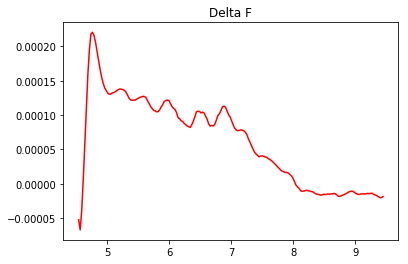

In [31]:
Kb=3.166811429e-6
kbt = Kb*300.0

cutoff = 5.0/0.529177
starting = 2.4/0.529177
grids = np.linspace(starting, cutoff, 200)

def ibi(r):
    try:
        g_ref = spline_target(r*0.529177)
        g_calc = spline_calc(r*0.529177)
        delta_f = kbt*math.log(g_calc/g_ref)
        return delta_f
    except:
        return 0.0

fs = [ibi(r) for r in grids]
    
plt.plot(grids, fs, 'r-')
plt.title('Delta F')
plt.show()

<IPython.core.display.Javascript object>


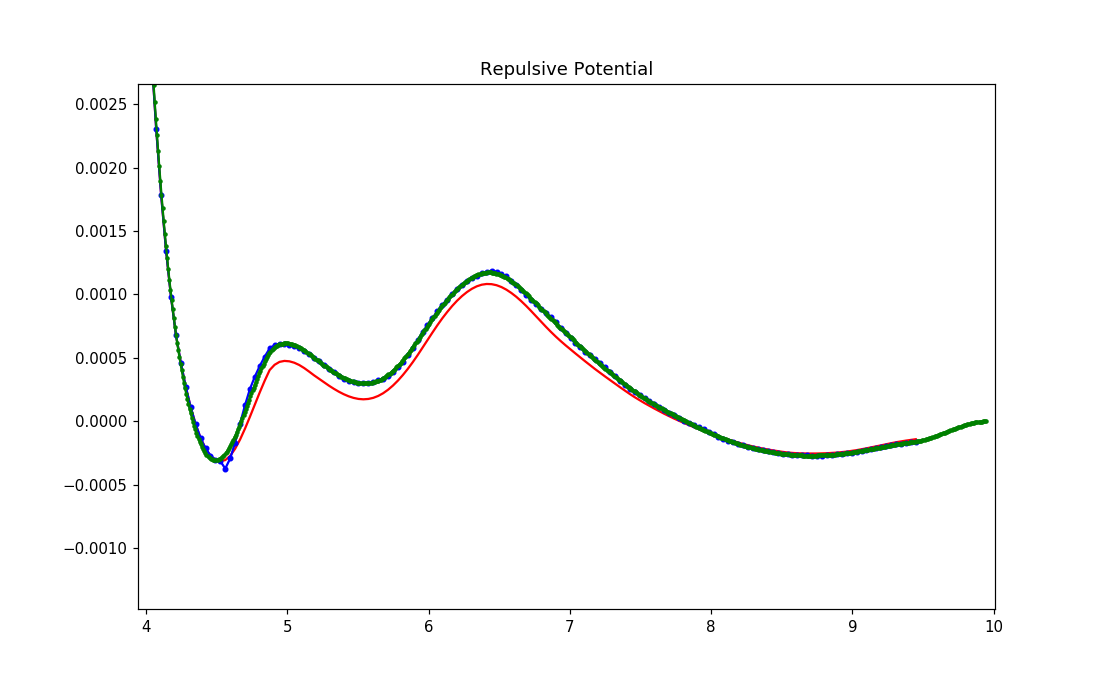

In [35]:
%matplotlib notebook
skfile = RepulsivePotenial.from_file('dftb/iter_2_big/O-O.skf')
fit_start = 4.5
grids = np.linspace(fit_start-2.0, cutoff, 200) 
final_rep = []
ori_rep = []
fs = []
for r in grids:
    if r <= starting:
        fs.append(0.0)
        final_rep.append(skfile.eval(r))
    else:
        fs.append(ibi(r))
        final_rep.append(skfile.eval(r)+ibi(r))
    ori_rep.append(skfile.eval(r))

final_rep_smooth = savitzky_golay(np.array(final_rep), 19, 3)

final_grids = []
final_pot = []
for r in skfile.knots:
    if r < fit_start-1.0:
        final_grids.append(r)
        final_pot.append(skfile.eval(r))
for r, v in zip(grids, final_rep_smooth):
    if r >= fit_start-1.0:
        final_grids.append(r)
        final_pot.append(v)

real_cutoff = cutoff+0.5
final_grids.append(real_cutoff)
final_pot.append(0.0)

first_deriv = skfile.eval(final_grids[0], 1)
final_splines = CubicSpline(final_grids, final_pot, bc_type=((1, first_deriv), (1, 0.0)))

ploting_grids = np.linspace(skfile.knots[0], real_cutoff, 1000)

#plt.plot(grids, fs, 'r-')
plt.plot(grids, ori_rep, 'r-')
plt.plot(grids, final_rep, 'bo-', markersize=3)
plt.plot(ploting_grids, final_splines(ploting_grids), 'go-', markersize=2)
plt.title('Repulsive Potential')
plt.show()
# plt.xlim(4, 10)
# plt.ylim(-0.002, 0.005)

In [36]:
#Fit the first derivatives
resolution = 0.01
nknots = int((real_cutoff - skfile.knots[0])/resolution)+1
final_knots = np.linspace(skfile.knots[0], real_cutoff, nknots)
pot_values = [final_splines(r, 0) for r in final_knots]
first_derivs = [final_splines(r, 1) for r in final_knots]
second_deriv = skfile.eval(final_knots[0], 2)
first_derivs_splines = CubicSpline(final_knots, first_derivs, bc_type=((1, second_deriv), (1, 0.0)))
# print(first_derivs_splines.c)
a4, a3, a2, a1 = first_derivs_splines.c
# print(first_derivs[0], a1[0])
# print(len(first_derivs_splines.x), len(a1))

r = skfile.knots[0]
new_expA = -first_derivs_splines(r,1)/first_derivs_splines(r) 
new_expB = math.log(-first_derivs_splines(r)/new_expA) + new_expA*r
new_expC = final_splines(r, 0) - math.exp(-new_expA*r+new_expB)
# print(new_expA, new_expB, new_expC)
# print(skfile.expA, skfile.expB, skfile.expC)

with open('output_3.rep', 'w') as f:
    print('Spline4', file=f)
    print('{} {:<7.4f}'.format(len(a1), real_cutoff), file=f)
    print(new_expA, new_expB, new_expC, file=f)
    
    for i in range(len(a1)):
        print('{:<7.4f} {:<7.4f} {:18.10E} {:18.10E} {:18.10E} {:18.10E} {:18.10E}'.format(
            first_derivs_splines.x[i], first_derivs_splines.x[i+1], pot_values[i], a1[i], a2[i]/2.0, a3[i]/3.0, a4[i]/4.0
        ), file=f)

# Iteration 4

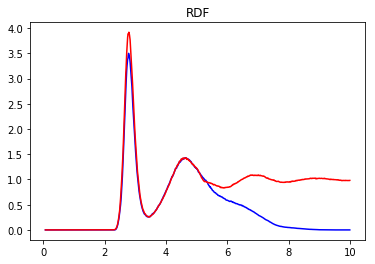

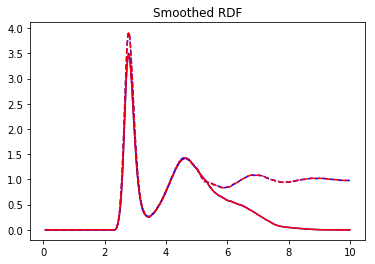

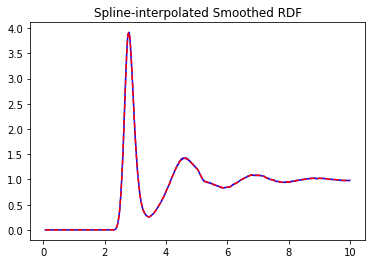

In [4]:
target_rdf = loadrdf('cp2k/rdf_oo_py.dat')
calc_rdf = loadrdf('dftb/iter_3_big/rdf_oo.dat')
plt.plot(target_rdf[0], target_rdf[1], 'b-')
plt.plot(calc_rdf[0], calc_rdf[1], 'r-')
plt.title('RDF')
plt.show()
target_ys = savitzky_golay(target_rdf[1], 19, 3)
plt.plot(target_rdf[0], target_rdf[1], 'b-')
plt.plot(target_rdf[0], target_ys, 'r-')
calc_ys = savitzky_golay(calc_rdf[1], 19, 3)
plt.plot(calc_rdf[0], calc_rdf[1], 'b--')
plt.plot(calc_rdf[0], calc_ys, 'r--')
plt.title('Smoothed RDF')
plt.show()
spline_target = CubicSpline(target_rdf[0], target_ys)
spline_calc = CubicSpline(calc_rdf[0], calc_ys)
plt.plot(calc_rdf[0], calc_rdf[1], 'b-')
plt.plot(calc_rdf[0], spline_calc(calc_rdf[0]), 'r--')
plt.title('Spline-interpolated Smoothed RDF')
plt.show()

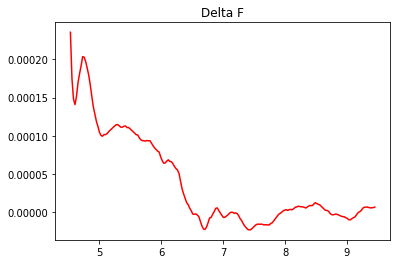

In [13]:
Kb=3.166811429e-6
kbt = Kb*300.0

cutoff = 5.0/0.529177
starting = 2.4/0.529177
grids = np.linspace(starting, cutoff, 200)

def ibi(r):
    try:
        g_ref = spline_target(r*0.529177)
        g_calc = spline_calc(r*0.529177)
        delta_f = kbt*math.log(g_calc/g_ref)
        return delta_f
    except:
        return 0.0

fs = [ibi(r) for r in grids]
    
plt.plot(grids, fs, 'r-')
plt.title('Delta F')
plt.show()

<IPython.core.display.Javascript object>


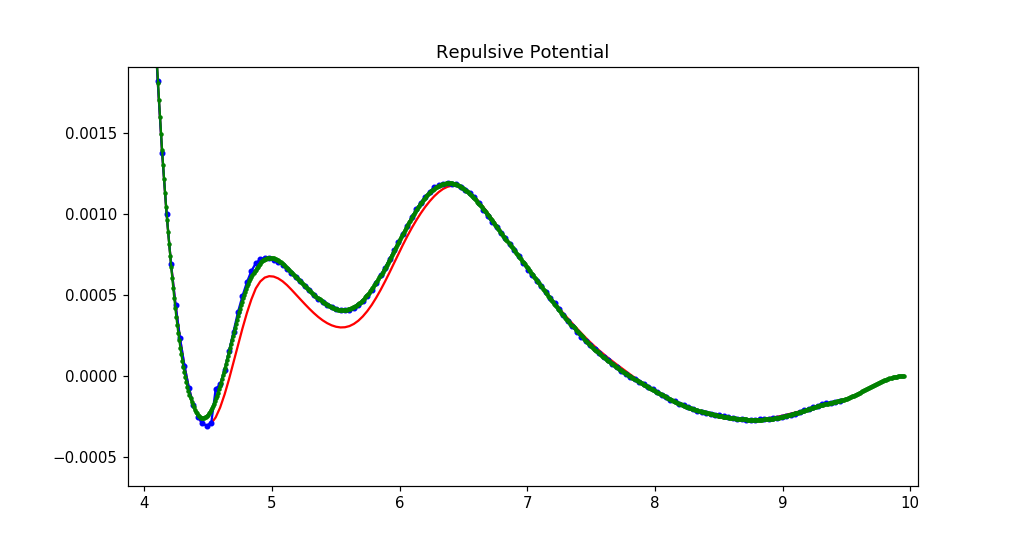

In [16]:
%matplotlib notebook
skfile = RepulsivePotenial.from_file('dftb/iter_3_big/O-O.skf')
fit_start = 4.5
grids = np.linspace(fit_start-2.0, cutoff, 200) 
final_rep = []
ori_rep = []
fs = []
for r in grids:
    if r <= starting:
        fs.append(0.0)
        final_rep.append(skfile.eval(r))
    else:
        fs.append(ibi(r))
        final_rep.append(skfile.eval(r)+ibi(r))
    ori_rep.append(skfile.eval(r))

final_rep_smooth = savitzky_golay(np.array(final_rep), 19, 3)

final_grids = []
final_pot = []
for r in skfile.knots:
    if r < fit_start-1.0:
        final_grids.append(r)
        final_pot.append(skfile.eval(r))
for r, v in zip(grids, final_rep_smooth):
    if r >= fit_start-1.0:
        final_grids.append(r)
        final_pot.append(v)

real_cutoff = cutoff+0.5
final_grids.append(real_cutoff)
final_pot.append(0.0)

first_deriv = skfile.eval(final_grids[0], 1)
final_splines = CubicSpline(final_grids, final_pot, bc_type=((1, first_deriv), (1, 0.0)))

ploting_grids = np.linspace(skfile.knots[0], real_cutoff, 1000)

#plt.plot(grids, fs, 'r-')
plt.plot(grids, ori_rep, 'r-')
plt.plot(grids, final_rep, 'bo-', markersize=3)
plt.plot(ploting_grids, final_splines(ploting_grids), 'go-', markersize=2)
plt.title('Repulsive Potential')
plt.show()
# plt.xlim(4, 10)
# plt.ylim(-0.002, 0.005)

In [8]:
def write_final_sk(previous_skfile, filename, ori_skfile, current_splines, real_cutoff, resolution=0.01):
    #Fit the first derivatives
    
    nknots = int((real_cutoff - ori_skfile.knots[0])/resolution)+1
    final_knots = np.linspace(ori_skfile.knots[0], real_cutoff, nknots)
    pot_values = [current_splines(r, 0) for r in final_knots]
    first_derivs = [current_splines(r, 1) for r in final_knots]
    second_deriv = ori_skfile.eval(final_knots[0], 2)
    first_derivs_splines = CubicSpline(final_knots, first_derivs, bc_type=((1, second_deriv), (1, 0.0)))

    a4, a3, a2, a1 = first_derivs_splines.c

    r = ori_skfile.knots[0]
    new_expA = -first_derivs_splines(r,1)/first_derivs_splines(r) 
    new_expB = math.log(-first_derivs_splines(r)/new_expA) + new_expA*r
    new_expC = current_splines(r, 0) - math.exp(-new_expA*r+new_expB)


    with open(filename, 'w') as f, open(previous_skfile, 'r') as fin:
        for line in fin:
            if 'Spline' in line:
                break
            print(line, end='', file=f)
            
        print('Spline4', file=f)
        print('{} {:<7.4f}'.format(len(a1), real_cutoff), file=f)
        print(new_expA, new_expB, new_expC, file=f)
    
        for i in range(len(a1)):
            print('{:<7.4f} {:<7.4f} {:18.10E} {:18.10E} {:18.10E} {:18.10E} {:18.10E}'.format(
            first_derivs_splines.x[i], first_derivs_splines.x[i+1], pot_values[i], a1[i], a2[i]/2.0, a3[i]/3.0, a4[i]/4.0
            ), file=f)

In [24]:
write_final_sk('dftb/iter_3_big/O-O.skf', 'outputs/O-O.iter_4.skf', skfile, final_splines, real_cutoff)

# Iteration 5

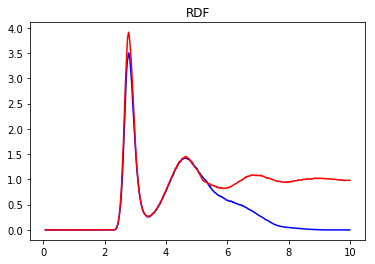

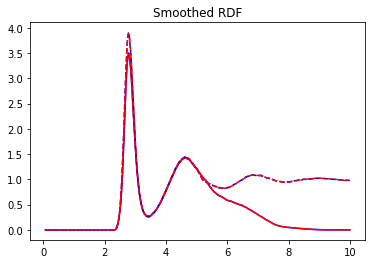

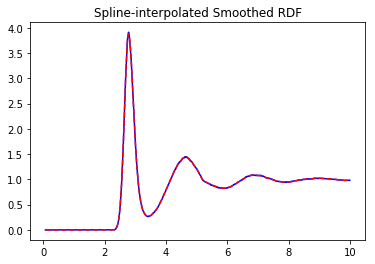

In [4]:
target_rdf = loadrdf('cp2k/rdf_oo_py.dat')
calc_rdf = loadrdf('dftb/iter_4_big/rdf_oo.dat')
plt.plot(target_rdf[0], target_rdf[1], 'b-')
plt.plot(calc_rdf[0], calc_rdf[1], 'r-')
plt.title('RDF')
plt.show()
target_ys = savitzky_golay(target_rdf[1], 19, 3)
plt.plot(target_rdf[0], target_rdf[1], 'b-')
plt.plot(target_rdf[0], target_ys, 'r-')
calc_ys = savitzky_golay(calc_rdf[1], 19, 3)
plt.plot(calc_rdf[0], calc_rdf[1], 'b--')
plt.plot(calc_rdf[0], calc_ys, 'r--')
plt.title('Smoothed RDF')
plt.show()
spline_target = CubicSpline(target_rdf[0], target_ys)
spline_calc = CubicSpline(calc_rdf[0], calc_ys)
plt.plot(calc_rdf[0], calc_rdf[1], 'b-')
plt.plot(calc_rdf[0], spline_calc(calc_rdf[0]), 'r--')
plt.title('Spline-interpolated Smoothed RDF')
plt.show()

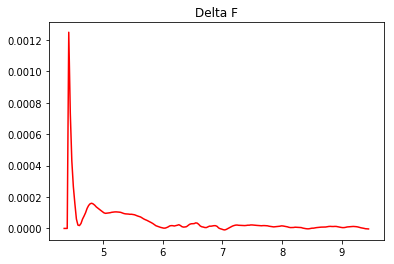

In [5]:
Kb=3.166811429e-6
kbt = Kb*300.0

cutoff = 5.0/0.529177
starting = 2.3/0.529177
grids = np.linspace(starting, cutoff, 200)

def ibi(r):
    try:
        g_ref = spline_target(r*0.529177)
        g_calc = spline_calc(r*0.529177)
        delta_f = kbt*math.log(g_calc/g_ref)
        return delta_f
    except:
        return 0.0

fs = [ibi(r) for r in grids]
    
plt.plot(grids, fs, 'r-')
plt.title('Delta F')
plt.show()

<IPython.core.display.Javascript object>


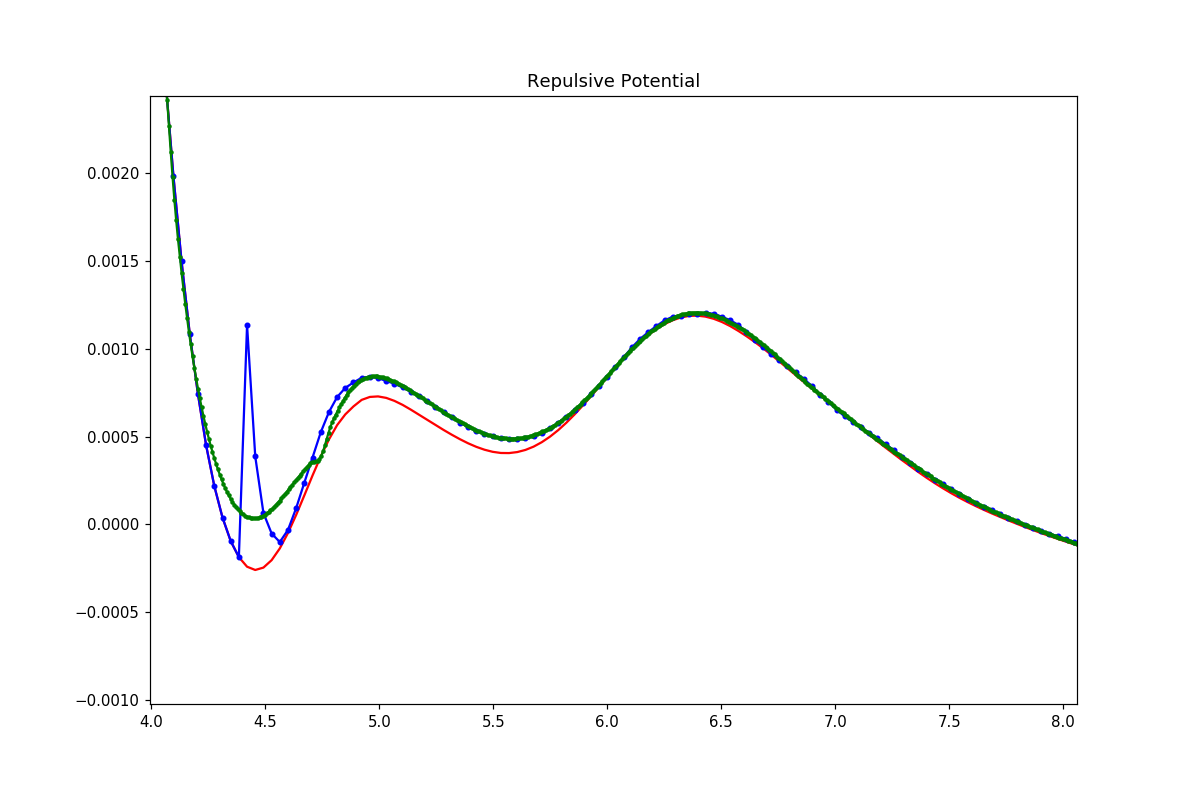

In [14]:
%matplotlib notebook
skfile = RepulsivePotenial.from_file('dftb/iter_4_big/O-O.skf')

fit_start = 4.3
grids = np.linspace(fit_start-2.0, cutoff, 200) 
final_rep = []
ori_rep = []
fs = []
for r in grids:
    if r <= starting:
        fs.append(0.0)
        final_rep.append(skfile.eval(r))
    else:
        fs.append(ibi(r))
        final_rep.append(skfile.eval(r)+ibi(r))
    ori_rep.append(skfile.eval(r))

final_rep_smooth = savitzky_golay(np.array(final_rep), 19, 3)

final_grids = []
final_pot = []
for r in skfile.knots:
    if r < fit_start-1.0:
        final_grids.append(r)
        final_pot.append(skfile.eval(r))
for r, v in zip(grids, final_rep_smooth):
    if r >= fit_start-1.0:
        final_grids.append(r)
        final_pot.append(v)

real_cutoff = cutoff+0.5
final_grids.append(real_cutoff)
final_pot.append(0.0)

first_deriv = skfile.eval(final_grids[0], 1)
final_splines = CubicSpline(final_grids, final_pot, bc_type=((1, first_deriv), (1, 0.0)))

ploting_grids = np.linspace(skfile.knots[0], real_cutoff, 1000)

#plt.plot(grids, fs, 'r-')
plt.plot(grids, ori_rep, 'r-')
plt.plot(grids, final_rep, 'bo-', markersize=3)
plt.plot(ploting_grids, final_splines(ploting_grids), 'go-', markersize=2)
plt.title('Repulsive Potential')
plt.show()
# plt.xlim(4, 10)
# plt.ylim(-0.002, 0.005)

In [9]:
write_final_sk('dftb/iter_4_big/O-O.skf', 'outputs/O-O.iter_5.skf', skfile, final_splines, real_cutoff)

In [10]:
starting

4.346371818881017

# Iteration 6

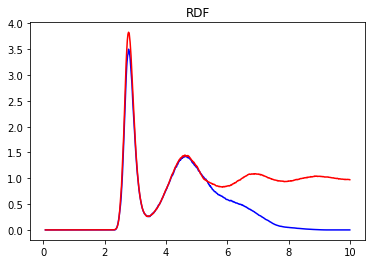

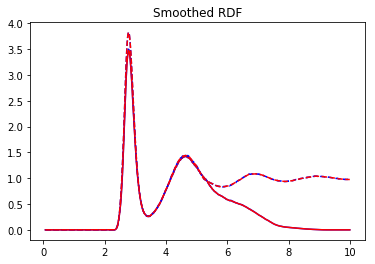

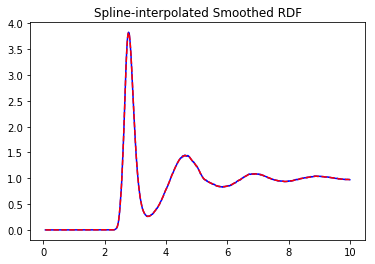

In [3]:
target_rdf = loadrdf('cp2k/rdf_oo_py.dat')
calc_rdf = loadrdf('dftb/iter_5_big/rdf_oo.dat')
plt.plot(target_rdf[0], target_rdf[1], 'b-')
plt.plot(calc_rdf[0], calc_rdf[1], 'r-')
plt.title('RDF')
plt.show()
target_ys = savitzky_golay(target_rdf[1], 19, 3)
plt.plot(target_rdf[0], target_rdf[1], 'b-')
plt.plot(target_rdf[0], target_ys, 'r-')
calc_ys = savitzky_golay(calc_rdf[1], 19, 3)
plt.plot(calc_rdf[0], calc_rdf[1], 'b--')
plt.plot(calc_rdf[0], calc_ys, 'r--')
plt.title('Smoothed RDF')
plt.show()
spline_target = CubicSpline(target_rdf[0], target_ys)
spline_calc = CubicSpline(calc_rdf[0], calc_ys)
plt.plot(calc_rdf[0], calc_rdf[1], 'b-')
plt.plot(calc_rdf[0], spline_calc(calc_rdf[0]), 'r--')
plt.title('Spline-interpolated Smoothed RDF')
plt.show()

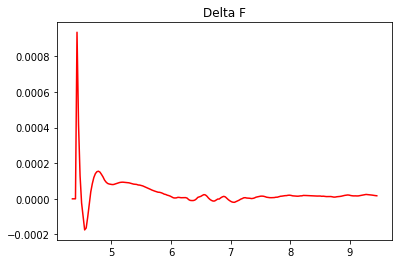

In [4]:
Kb=3.166811429e-6
kbt = Kb*300.0

cutoff = 5.0/0.529177
starting = 2.3/0.529177
grids = np.linspace(starting, cutoff, 200)

def ibi(r):
    try:
        g_ref = spline_target(r*0.529177)
        g_calc = spline_calc(r*0.529177)
        delta_f = kbt*math.log(g_calc/g_ref)
        return delta_f
    except:
        return 0.0

fs = [ibi(r) for r in grids]
    
plt.plot(grids, fs, 'r-')
plt.title('Delta F')
plt.show()

<IPython.core.display.Javascript object>


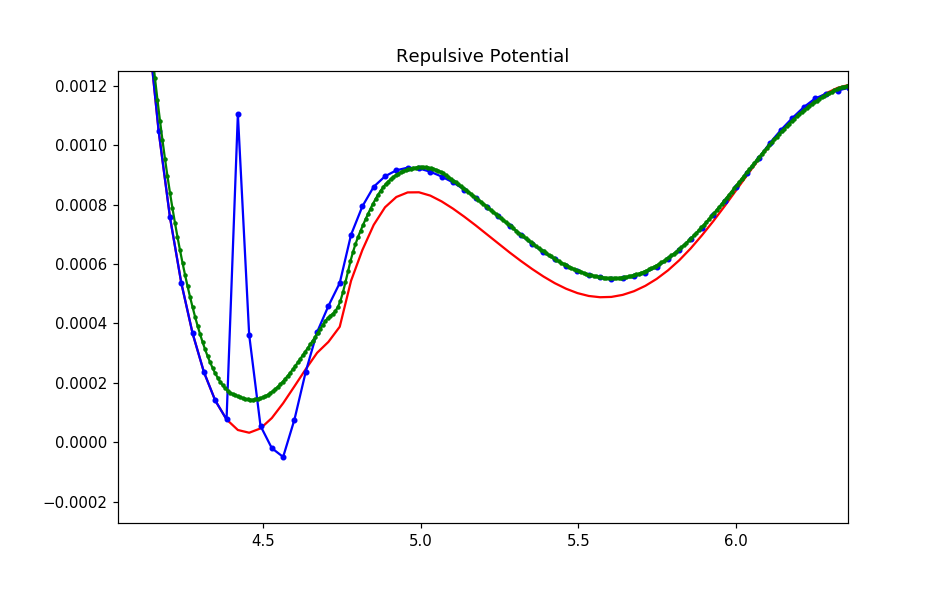

In [6]:
%matplotlib notebook
skfile = RepulsivePotenial.from_file('dftb/iter_5_big/O-O.skf')

fit_start = 4.3
grids = np.linspace(fit_start-2.0, cutoff, 200) 
final_rep = []
ori_rep = []
fs = []
for r in grids:
    if r <= starting:
        fs.append(0.0)
        final_rep.append(skfile.eval(r))
    else:
        fs.append(ibi(r))
        final_rep.append(skfile.eval(r)+ibi(r))
    ori_rep.append(skfile.eval(r))

final_rep_smooth = savitzky_golay(np.array(final_rep), 19, 3)

final_grids = []
final_pot = []
for r in skfile.knots:
    if r < fit_start-1.0:
        final_grids.append(r)
        final_pot.append(skfile.eval(r))
for r, v in zip(grids, final_rep_smooth):
    if r >= fit_start-1.0:
        final_grids.append(r)
        final_pot.append(v)

real_cutoff = cutoff+0.5
final_grids.append(real_cutoff)
final_pot.append(0.0)

first_deriv = skfile.eval(final_grids[0], 1)
final_splines = CubicSpline(final_grids, final_pot, bc_type=((1, first_deriv), (1, 0.0)))

ploting_grids = np.linspace(skfile.knots[0], real_cutoff, 1000)

#plt.plot(grids, fs, 'r-')
plt.plot(grids, ori_rep, 'r-')
plt.plot(grids, final_rep, 'bo-', markersize=3)
plt.plot(ploting_grids, final_splines(ploting_grids), 'go-', markersize=2)
plt.title('Repulsive Potential')
plt.show()
# plt.xlim(4, 10)
# plt.ylim(-0.002, 0.005)

In [9]:
write_final_sk('dftb/iter_5_big/O-O.skf', 'outputs/O-O.iter_6.skf', skfile, final_splines, real_cutoff)